In [1]:
import numpy as np
import pandas as pd
import os
import random, re, math
import tensorflow as tf, tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from kaggle_datasets import KaggleDatasets

print(tf.__version__)
print(tf.keras.__version__)

2.1.0
2.2.4-tf


In [2]:
!pip install efficientnet
import efficientnet.tfkeras as efn

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


#### TPU

In [3]:
AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)


# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


(1365, 2048, 3)


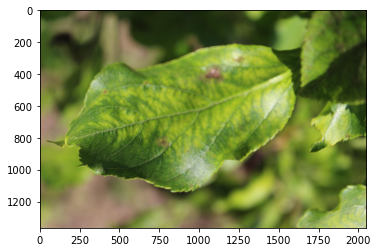

In [4]:
from matplotlib import pyplot as plt

img = plt.imread('../input/plant-pathology-2020-fgvc7/images/Train_0.jpg')
print(img.shape)
plt.imshow(img)

In [5]:
path='../input/plant-pathology-2020-fgvc7/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
sub = pd.read_csv(path + 'sample_submission.csv')

train_paths = train.image_id.apply(lambda x: GCS_DS_PATH + '/images/' + x + '.jpg').values
test_paths = test.image_id.apply(lambda x: GCS_DS_PATH + '/images/' + x + '.jpg').values

train_labels = train.loc[:, 'healthy':].values

In [6]:
nb_classes = 4
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
print(BATCH_SIZE)
img_size = 768
aspect = 1
EPOCHS = 40

64


(1365, 2048, 3)


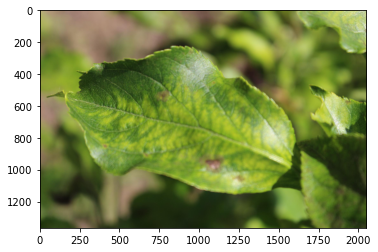

In [7]:
def decode_image(filename, label=None, image_size=(img_size, img_size*aspect)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.central_crop(image, central_fraction=0.9)
    image = tf.image.resize(image, image_size)
    if label is None:
        return image
    else:
        return image, label
    
def data_augment(image, label=None, seed=4321):
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    rd = np.random.uniform()
#     if rd > 0.5:
#         image = tf.image.rot90(image)
           
    if label is None:
        return image
    else:
        return image, label
    
img = data_augment(plt.imread('../input/plant-pathology-2020-fgvc7/images/Train_0.jpg'))
print(img.shape)
plt.imshow(img)

In [8]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )

In [9]:
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

In [10]:
# LR_START = 0.00001
# LR_MAX = 0.0002 * strategy.num_replicas_in_sync
# LR_MIN = 0.00001
# LR_RAMPUP_EPOCHS = 15
# LR_SUSTAIN_EPOCHS = 5
# LR_EXP_DECAY = .8

# def lrfn(epoch):
#     if epoch < LR_RAMPUP_EPOCHS:
#         lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
#     elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
#         lr = LR_MAX
#     else:
#         lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
#     return lr
    
# lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

# rng = [i for i in range(EPOCHS)]
# y = [lrfn(x) for x in rng]
# plt.plot(rng, y)
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

Learning rate schedule: 1e-05 to 0.0008 to 1.47e-05


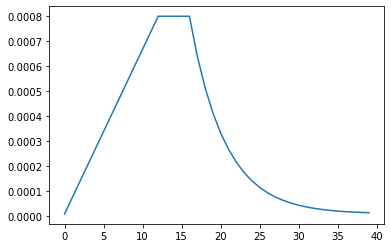

In [11]:
LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 12
LR_SUSTAIN_EPOCHS = 4
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [12]:
def get_model():
    base_model =  efn.EfficientNetB7(weights='imagenet', include_top=False, pooling='avg', input_shape=(img_size, img_size*aspect, 3))
    x = base_model.output
    predictions = Dense(nb_classes, activation="softmax")(x)
    return Model(inputs=base_model.input, outputs=predictions)

In [13]:
with strategy.scope():
    model = get_model()
    
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),metrics=['accuracy', 'AUC'])

258441216/258434480 [==============================] - 8s 0us/step


In [14]:
%%time
history = model.fit(
                train_dataset, 
                steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
                callbacks=[lr_callback],
                epochs=EPOCHS
            )

Train for 28 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/40
28/28 [==============================] - 338s 12s/step - loss: 1.3445 - accuracy: 0.3527 - AUC: 0.6140

Epoch 00002: LearningRateScheduler reducing learning rate to 7.583333333333334e-05.
Epoch 2/40
28/28 [==============================] - 28s 1s/step - loss: 0.8675 - accuracy: 0.7054 - AUC: 0.9100

Epoch 00003: LearningRateScheduler reducing learning rate to 0.00014166666666666668.
Epoch 3/40
28/28 [==============================] - 37s 1s/step - loss: 0.3977 - accuracy: 0.8929 - AUC: 0.9825

Epoch 00004: LearningRateScheduler reducing learning rate to 0.00020750000000000003.
Epoch 4/40
28/28 [==============================] - 40s 1s/step - loss: 0.3126 - accuracy: 0.8929 - AUC: 0.9866

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0002733333333333334.
Epoch 5/40
28/28 [==============================] - 40s 1s/step - loss: 0.2602 - accuracy: 0.9241 - AUC: 0.9893

Epoch 0

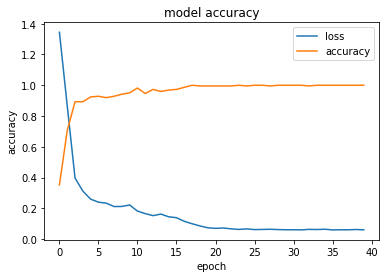

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper right')
plt.show()

In [16]:
%%time
probs = model.predict(test_dataset)

CPU times: user 9.73 s, sys: 313 ms, total: 10 s
Wall time: 2min 12s


In [17]:
sub.loc[:, 'healthy':] = probs
sub.to_csv('submission.csv', index=False)
sub.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.001087,0.001780,0.995430,0.001703
1,Test_1,0.001263,0.001153,0.995877,0.001707
2,Test_2,0.001439,0.000907,0.002008,0.995646
3,Test_3,0.993644,0.001220,0.002652,0.002484
4,Test_4,0.002395,0.001943,0.994708,0.000954
